<a href="https://colab.research.google.com/github/AlirezaSamari/DeepLearning-Pytorch-fastai-and/blob/main/09_Convolutional_Neural_Networks_(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.vision.all import *
from fastcore import *

In [2]:
top_edge = tensor([[-1, -1, -1],
                   [0, 0, 0],
                   [1, 1, 1]]).float()

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/valid')]

In [5]:
im3 = Image.open(path/'train'/'3'/'12.png')
im3

In [6]:
im3_t = tensor(im3)
im3_t[0:3, 0:3] * top_edge

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [7]:
(im3_t[0:3, 0:3] * top_edge).sum()

tensor(0.)

In [8]:
from pandas import DataFrame
df = DataFrame(im3_t[:10, :20])
df.style.background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [9]:
(im3_t[4:7,6:9] * top_edge).sum()

tensor(762.)

In [10]:
(im3_t[7:10,17:20] * top_edge).sum()

tensor(-29.)

In [11]:
(im3_t[4:7,6:9] * top_edge).sum()

tensor(762.)

In [12]:
(im3_t[7:10,17:20] * top_edge).sum()

tensor(-29.)

In [13]:
def apply_kernel(row, col, kernel):
  return (im3_t[row-1:row+2, col-1:col+2]*kernel).sum()

In [14]:
apply_kernel(5, 7, top_edge)

tensor(762.)

In [15]:
apply_kernel(8, 18, top_edge)

tensor(-29.)

In [16]:
[[(i, j) for j in range(1, 5)] for i in range(1, 5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

In [17]:
rng = range(1, 27)
top_edge3 = tensor([[apply_kernel(i, j, top_edge) for j in rng] for i in rng])

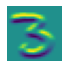

In [18]:
show_image(top_edge3)

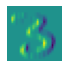

In [19]:
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()

left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])

show_image(left_edge3);
     

In [20]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])

In [21]:
edge_kernels

tensor([[[-1.,  1.,  0.],
         [-1.,  1.,  0.],
         [-1.,  1.,  0.]],

        [[-1., -1., -1.],
         [ 0.,  0.,  0.],
         [ 1.,  1.,  1.]],

        [[ 0., -1.,  1.],
         [-1.,  1.,  0.],
         [ 1.,  0.,  0.]],

        [[ 1., -1.,  0.],
         [ 0.,  1., -1.],
         [ 0.,  0.,  1.]]])

In [22]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb,yb = to_cpu(xb),to_cpu(yb)
xb.shape

torch.Size([64, 1, 28, 28])

In [23]:
edge_kernels.shape, edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [24]:
edge_kernels = edge_kernels.unsqueeze(1)

In [25]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

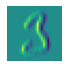

In [26]:
show_image(batch_features[0,0])

# Creating CNN

In [27]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

In [28]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [29]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1, 30, kernel_size=(3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(30, 1, kernel_size=(3, 3), padding=1)
)

In [30]:
broken_cnn

Sequential(
  (0): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(30, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [31]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

In [32]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [33]:
simple_cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,32),           #2x2
    conv(32,2, act=False), #1x1
    Flatten(),
)
     

In [34]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [35]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

SuggestedLRs(valley=0.005248074419796467)

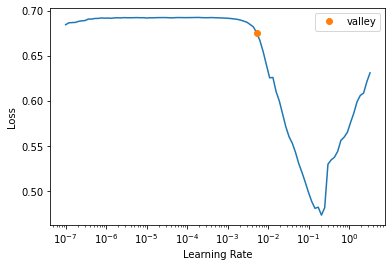

In [36]:
learn.lr_find()

In [37]:
learn.fit_one_cycle(n_epoch = 2, lr_max=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.060617,0.046022,0.983808,00:11
1,0.023579,0.027678,0.989205,00:11


In [38]:
learn.unfreeze()

In [39]:
learn.fit_one_cycle(n_epoch = 2, lr_max=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.027034,0.023119,0.992640,00:12
1,0.013658,0.018243,0.994603,00:11
